In [1]:
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import UNet3D
from random import randint
from PIL import Image
import torch.optim as optim
import time

#### Set the visible GPU

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


We have 330 subjects, for every subject, there is 3 planes for T1w image, and 3 planes for Parc_5 image.
Pick a random subject

# I. Data Loading and preprocessing

In [3]:
sub_idx = randint(0,330)
print('sub index:',sub_idx)

T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
T1s_dir = '/home/xiaoyu/MRIdata/T1w/sagittal/sub{}'.format(sub_idx)
T1c_dir = '/home/xiaoyu/MRIdata/T1w/coronal/sub{}'.format(sub_idx)

parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
parc5s_dir = '/home/xiaoyu/MRIdata/parc_5/sagittal/sub{}'.format(sub_idx)
parc5c_dir = '/home/xiaoyu/MRIdata/parc_5/coronal/sub{}'.format(sub_idx)

T1a_list = os.listdir(T1a_dir)
T1s_list = os.listdir(T1s_dir)
T1c_list = os.listdir(T1c_dir)

parc5a_list = os.listdir(parc5a_dir)
parc5s_list = os.listdir(parc5s_dir)
parc5c_list = os.listdir(parc5c_dir)

print('\nT1w Axial slices num:',len(T1a_list))
print('T1w Sagittal slices num:',len(T1s_list))
print('T1w Coronal slices num:',len(T1c_list))

print('\nParc5 Axial slices num:',len(parc5a_list))
print('Parc5 Sagittal slices num:',len(parc5s_list))
print('Parc5 Coronal slices num:',len(parc5c_list))

sub index: 240

T1w Axial slices num: 182
T1w Sagittal slices num: 217
T1w Coronal slices num: 182

Parc5 Axial slices num: 182
Parc5 Sagittal slices num: 217
Parc5 Coronal slices num: 182


In [4]:
# axial plane
for i in range(len(T1a_list)):
    T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
    T1a_str = T1a_list[i]
    parc5a_str = parc5a_list[i]
    T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
    parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
    
    print('Image array data type: ', T1a_arr.dtype)
    print('Mask array data type: ', parc5a_arr.dtype)
    
    # make 2 tensors from the numpy array for image and mask respectively
    T1a_tensor = torch.from_numpy(T1a_arr)
    parc5a_tensor = torch.from_numpy(parc5a_arr)
    
    # observe the data size of the image and mask
    print('\nImage data size: ', T1a_tensor.size())
    print('Mask data size:', parc5a_tensor.size())
    
    if i ==0:
        break    

Image array data type:  uint8
Mask array data type:  uint8

Image data size:  torch.Size([182, 217])
Mask data size: torch.Size([182, 217])


#### Define a funciton for the visualization

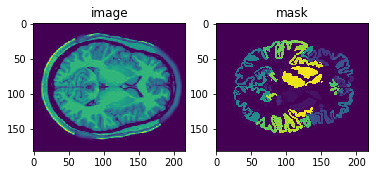

In [5]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()
    
# test the function
show_mask(T1a_arr, parc5a_arr)

### Find the unique color in mask

In [6]:
colors = torch.tensor([])
for i in range(len(T1a_list)):
    
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
   
    parc5a_str = parc5a_list[i]
   
    parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
    
    parc5a_tensor = torch.from_numpy(parc5a_arr)
    
    unique_color = torch.unique(parc5a_tensor).type(torch.FloatTensor)
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)
print(colors.dtype)
print(colors.size())

tensor([  0.,   6.,   5.,   3.,   1.,   8.,   9.,  17., 195., 215., 197., 205.,
        211., 210., 199., 200., 206., 209., 221., 201., 204., 216.,   7.,  18.,
          4.,   2.,  13.,  15.,  11.,  22.,  19., 192., 165., 187., 220., 189.,
        202., 231., 218., 207., 227., 208., 214.,  10.,  12.,  20.,  14., 170.,
        171., 162., 188., 173., 185., 183., 212., 193., 219., 190., 213., 226.,
        234., 222., 174., 166., 184., 198., 178., 180., 224., 186., 230., 217.,
        223., 196., 240., 155., 168., 179., 175., 203., 194., 191., 232., 167.,
        181., 177., 235.,  21., 163.,  16.,  29., 182., 176., 172., 126., 142.,
        140., 154., 169., 233., 124., 128., 120., 122., 229., 245.,  25., 138.,
        143., 134., 137., 125., 145.,  35., 117., 113., 118., 160., 129., 132.,
        130., 136., 144.,  26.,  45.,  48.,  32.,  23., 115., 127., 119., 100.,
        105., 121., 102., 107., 164., 239., 238., 141., 152., 149.,  33.,  39.,
         37.,  34.,  38.,  47.,  28., 10

Found that there are 256 unique color in the mask, so there are 256 classes. There is no need to map since the class label is [0,255]

#### Define the Training set Class

In [38]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, T1a_dir, parc5a_dir, transform=None):
        """
        Args:
            T1a_dir (string): Directory with T1w image in axial plane
            transform (callable): Optional transform to be applied on a sample
            parc5a_dir (string): Directory with parcellation scale 5 in axial plane
        """
        self.T1a_dir = T1a_dir
        self.transform = transform
        self.parc5a_dir = parc5a_dir
        
    def __len__(self):
        T1a_list = os.listdir(self.T1a_dir)
        return len(T1a_list)
    
    
    def __getitem__(self, idx):
        T1a_list = os.listdir(T1a_dir)
        parc5a_list = os.listdir(parc5a_dir)
        
        T1a_str = T1a_list[idx]
        print(T1a_str)
        T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
        T1a_tensor = torch.from_numpy(T1a_arr)
        
        compose_T1 = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.Resize((128,128),interpolation=Image.NEAREST),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        T1a_tensor = torch.unsqueeze(T1a_tensor, dim = 0)
        T1a_tensor = compose_T1(T1a_tensor)
              
        parc5a_str = parc5a_list[idx]
        print(parc5a_str)
        parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
        parc5a_tensor = torch.from_numpy(parc5a_arr)
        
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((128,128),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        parc5a_tensor = torch.unsqueeze(parc5a_tensor, dim = 0)
        parc5a_tensor = compose(parc5a_tensor)
        parc5a_tensor = parc5a_tensor.squeeze()
        
        parc5a_tensor = torch.round(parc5a_tensor / 0.0039).byte()
      
        sample = {'T1a':T1a_tensor, 'parc5a':parc5a_tensor}
        
        if self.transform:
            T1a = self.transform(T1a_tensor)
            sample = {'T1a':T1a, 'parc5a':parc5a}
            
        return sample

In [39]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
print('Total image number: {}'.format(len(train_data)))
colors = torch.tensor([])

for i in range(len(train_data)):
    sample = train_data[i]
    mask = sample['parc5a']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)

Total image number: 182
slice_73.jpg
slice_73.jpg
slice_8.jpg
slice_8.jpg
slice_43.jpg
slice_43.jpg
slice_180.jpg
slice_180.jpg
slice_45.jpg
slice_45.jpg
slice_41.jpg
slice_41.jpg
slice_93.jpg
slice_93.jpg
slice_80.jpg
slice_80.jpg
slice_76.jpg
slice_76.jpg
slice_50.jpg
slice_50.jpg
slice_24.jpg
slice_24.jpg
slice_119.jpg
slice_119.jpg
slice_5.jpg
slice_5.jpg
slice_3.jpg
slice_3.jpg
slice_125.jpg
slice_125.jpg
slice_42.jpg
slice_42.jpg
slice_25.jpg
slice_25.jpg
slice_71.jpg
slice_71.jpg
slice_151.jpg
slice_151.jpg
slice_68.jpg
slice_68.jpg
slice_166.jpg
slice_166.jpg
slice_132.jpg
slice_132.jpg
slice_141.jpg
slice_141.jpg
slice_15.jpg
slice_15.jpg
slice_83.jpg
slice_83.jpg
slice_47.jpg
slice_47.jpg
slice_161.jpg
slice_161.jpg
slice_49.jpg
slice_49.jpg
slice_146.jpg
slice_146.jpg
slice_104.jpg
slice_104.jpg
slice_133.jpg
slice_133.jpg
slice_137.jpg
slice_137.jpg
slice_149.jpg
slice_149.jpg
slice_14.jpg
slice_14.jpg
slice_75.jpg
slice_75.jpg
slice_175.jpg
slice_175.jpg
slice_171.jpg
slic

### Test the traindataset class 
We can see here 
* T1wa data is in the range [-1,1], the data type is torch.float32 
* parc5a data value is (0,1,2,3...255), data type is torch.uint8  

In [16]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
print('Total T1a image number: {}'.format(len(train_data)))

maximum = torch.tensor([0],dtype=torch.float32)
minimum = torch.tensor([0],dtype=torch.float32)

for i in range(len(train_data)):
    sample = train_data[i]
    T1a = sample['T1a']
    parc5a = sample['parc5a']
        
    maxi = torch.max(T1a)
    mini = torch.min(T1a)

    if maximum < maxi:
        maximum = torch.max(T1a)
    if minimum > mini:
        minimum = torch.min(T1a)
 
print(maximum)
print(minimum)

Total T1a image number: 182
tensor(1.)
tensor(-1.)


T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.3098)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


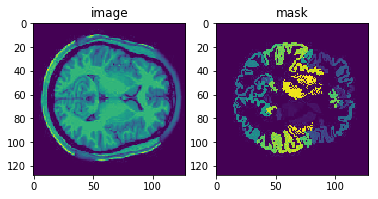

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.8902)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(39, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


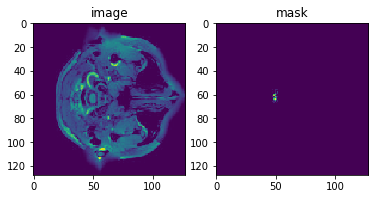

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.6314)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(237, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


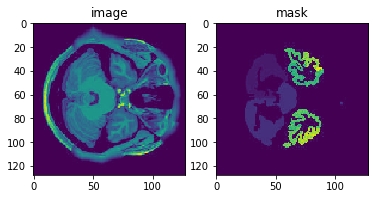

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(-1.)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(0, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


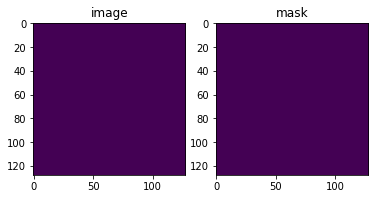

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5529)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(242, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


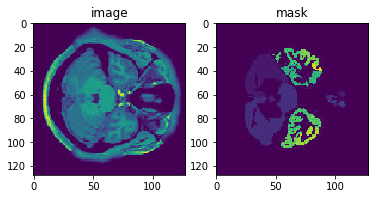

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5686)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(241, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


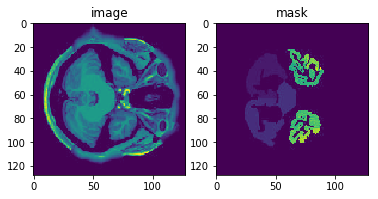

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5529)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


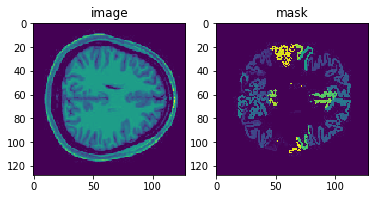

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5765)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


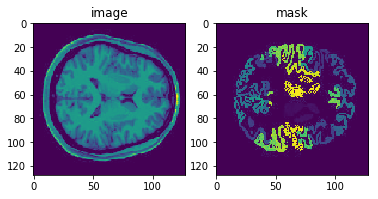

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.3176)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


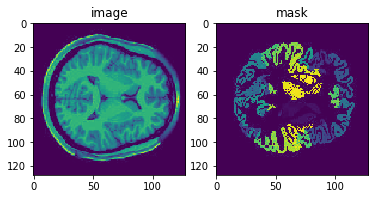

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5294)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


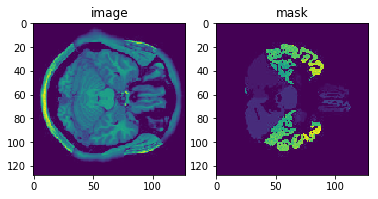

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(1.)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(43, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


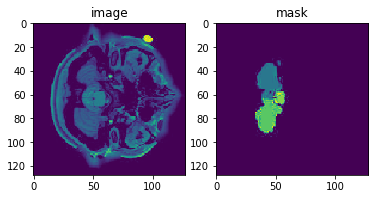

In [37]:
for i in range(len(train_data)):
    sample = train_data[i]
    T1a = sample['T1a']
    parc5a = sample['parc5a']
    
    print('T1a info:')
    print(T1a.size())
    print(T1a.dtype)
    print(torch.max(T1a))
    print(torch.min(T1a))
    
    print('\n parc5a info:')
    print(parc5a.dtype)
    print(parc5a.size())
    print(torch.max(parc5a))
    print(torch.min(parc5a))
    print(type(T1a))
    print('\nVisualization:')
    show_mask(T1a.squeeze(), parc5a)
    if i == 10:  
        break

### Use the dataloader in Pytorch to form the train dataset
Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [18]:
dataloader = DataLoader(train_data, batch_size = 5, shuffle = True, num_workers = 4)

In [19]:
print(len(dataloader))

37


In [20]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['T1a'].size())
    print(sample_batched['parc5a'].size())
    if i_batch ==0:
        break

torch.Size([5, 1, 128, 128])
torch.Size([5, 128, 128])


# II. Define the network

In [21]:
class double_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding =1), #same padding
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size = 3,padding =1), #same padding
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.doubleconv(x)
        return x

In [22]:
class down(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(down, self).__init__()
        self.downconv = nn.Sequential(
            nn.MaxPool2d(2, stride = 2),
            double_conv(in_channel, out_channel)
        )
    def forward(self, x):
        x = self.downconv(x)
        return x        

In [23]:
bs=5
x = torch.rand(bs,64,22,27)
net = down(64,128)
y = net(x)
print(y.size())

torch.Size([5, 128, 11, 13])


In [24]:
class up(nn.Module):
    def __init__(self,in_channel, out_channel):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channel, out_channel, kernel_size = 2, stride = 2)
        self.conv = double_conv(in_channel, out_channel)
    def forward(self, x1, x2):
        # after the convtranspose2d, the output W,H doubled.
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]  
        diffX = x2.size()[3] - x1.size()[3]
        # crop x2 
        x2 = x2[:,:,diffY//2:diffY//2+x1.size()[2] , diffX//2:diffX//2+x1.size()[3]] 
        x = torch.cat([x2,x1], dim = 1)
        x = self.conv(x)
        return x

In [25]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [26]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self):
        super(UNet, self).__init__() 
        
        
        self.conv_in = double_conv(1,8)
        self.down1 = down(8,16)
        self.down2 = down(16,32)
        self.down3 = down(32,64)
        self.down4 = down(64,128)
        
        self.up1 = up(128,64)
        self.up2 = up(64,32)
        self.up3 = up(32,16)
        self.up4 = up(16,8)
        self.conv_out = outconv(8,256)
        
       

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.conv_out(x)
        x = F.log_softmax(x, dim =1)
        return x

### Unet parameters

In [27]:
# input channel is 3, output channel is 1
unet = UNet()
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

nb_param=0
for param in unet.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

UNet(
  (conv_in): double_conv(
    (doubleconv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): down(
    (downconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (doubleconv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [29]:
bs=5
x=torch.rand(bs,1,128,128)
y = unet(x)
print(y.size())

torch.Size([5, 256, 128, 128])


### Make sure the current device

In [30]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [31]:
torch.cuda.device_count()

1

In [32]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [33]:
unet = unet.to(device)

In [34]:
print(unet_params[0].dtype)

torch.float32


### Define the loss function and learning rate

In [35]:
criterion = nn.NLLLoss()

#### Inputs size: bs x 1 x 182 x 217 tensor, which is in range [-1,1], data type is float32
#### Labels size: bs x 182 x 217 tensor, the values is 0,1,2,... 255, data type is uint8

In [36]:
optimizer = optim.Adam(unet.parameters() ,lr=0.001)


start=time.time()
for epoch in range(1,500):
   
    
    # define the running loss
    running_loss = 0
    running_error = 0
    num_batches=0
      
    for i_batch, sample_batched in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['T1a'], sample_batched['parc5a']
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = unet(inputs)
      
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
    
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )

       
print('Finish Training')

epoch= 1 	 time= 0.0212895671526591 min 	 loss= 5.582285455755286
epoch= 2 	 time= 0.04122862418492635 min 	 loss= 5.246456996814625
epoch= 3 	 time= 0.06122541824976603 min 	 loss= 4.9391323940174
epoch= 4 	 time= 0.0799445629119873 min 	 loss= 4.591304327990557
epoch= 5 	 time= 0.09619319041570028 min 	 loss= 4.194444759471996
epoch= 6 	 time= 0.11747728188832601 min 	 loss= 3.6798392050975077
epoch= 7 	 time= 0.14049909114837647 min 	 loss= 3.1298924265681087
epoch= 8 	 time= 0.1593483606974284 min 	 loss= 2.626964762404158
epoch= 9 	 time= 0.17567638158798218 min 	 loss= 2.1710294388435982
epoch= 10 	 time= 0.19133912324905394 min 	 loss= 1.8490363456107475
epoch= 11 	 time= 0.20738691488901775 min 	 loss= 1.6371858409933142
epoch= 12 	 time= 0.23041654825210572 min 	 loss= 1.4767600845646214
epoch= 13 	 time= 0.25325512091318764 min 	 loss= 1.307593000901712
epoch= 14 	 time= 0.27382498582204184 min 	 loss= 1.2184915349290177
epoch= 15 	 time= 0.2954853336016337 min 	 loss= 1.1352

epoch= 122 	 time= 2.412396077315013 min 	 loss= 0.666009181657353
epoch= 123 	 time= 2.432170323530833 min 	 loss= 0.6705514140225746
epoch= 124 	 time= 2.4548493067423505 min 	 loss= 0.6665657585537111
epoch= 125 	 time= 2.4778971989949543 min 	 loss= 0.6656654553638922
epoch= 126 	 time= 2.498807676633199 min 	 loss= 0.671921786424276
epoch= 127 	 time= 2.5161945899327596 min 	 loss= 0.6687465741022213
epoch= 128 	 time= 2.5320443431536357 min 	 loss= 0.6590805057738278
epoch= 129 	 time= 2.5487985849380492 min 	 loss= 0.6622311690369168
epoch= 130 	 time= 2.5646920720736186 min 	 loss= 0.6566053179873003
epoch= 131 	 time= 2.583492402235667 min 	 loss= 0.6625910723531568
epoch= 132 	 time= 2.6017319798469543 min 	 loss= 0.6473089637788566
epoch= 133 	 time= 2.6206466635068257 min 	 loss= 0.6555150610369604
epoch= 134 	 time= 2.640680265426636 min 	 loss= 0.6591689884662628
epoch= 135 	 time= 2.6605594595273336 min 	 loss= 0.6540388835443033
epoch= 136 	 time= 2.678673593203227 min 

epoch= 243 	 time= 4.806981654961904 min 	 loss= 0.6044658980256802
epoch= 244 	 time= 4.82511701186498 min 	 loss= 0.6034070078182865
epoch= 245 	 time= 4.846765359242757 min 	 loss= 0.5902156829833984
epoch= 246 	 time= 4.866309344768524 min 	 loss= 0.5851300627345571
epoch= 247 	 time= 4.8875451723734535 min 	 loss= 0.5868390541825745
epoch= 248 	 time= 4.911459267139435 min 	 loss= 0.5959402312700813
epoch= 249 	 time= 4.929812081654867 min 	 loss= 0.5947017671943113
epoch= 250 	 time= 4.951893901824951 min 	 loss= 0.5874560065064076
epoch= 251 	 time= 4.973500680923462 min 	 loss= 0.6023876727432818
epoch= 252 	 time= 4.996819452444712 min 	 loss= 0.5874772036599146
epoch= 253 	 time= 5.016026504834493 min 	 loss= 0.5948783465333887
epoch= 254 	 time= 5.035756552219391 min 	 loss= 0.5913805313207008
epoch= 255 	 time= 5.055125614007314 min 	 loss= 0.5841976863936194
epoch= 256 	 time= 5.075411053498586 min 	 loss= 0.582932409389901
epoch= 257 	 time= 5.093452016512553 min 	 loss= 

epoch= 364 	 time= 7.106371978918712 min 	 loss= 0.5899584502787203
epoch= 365 	 time= 7.127305221557617 min 	 loss= 0.5686060321089383
epoch= 366 	 time= 7.15125819047292 min 	 loss= 0.5724025187460152
epoch= 367 	 time= 7.171074549357097 min 	 loss= 0.5735652853508253
epoch= 368 	 time= 7.187984351317088 min 	 loss= 0.5810608304030186
epoch= 369 	 time= 7.207815476258596 min 	 loss= 0.5878216954501899
epoch= 370 	 time= 7.228976595401764 min 	 loss= 0.5775184040539898
epoch= 371 	 time= 7.250335450967153 min 	 loss= 0.5818980702677289
epoch= 372 	 time= 7.272311834494273 min 	 loss= 0.5755425876862293
epoch= 373 	 time= 7.297191182772319 min 	 loss= 0.5761234953596786
epoch= 374 	 time= 7.318260757128398 min 	 loss= 0.5775240101927036
epoch= 375 	 time= 7.338152074813843 min 	 loss= 0.5779533338586712
epoch= 376 	 time= 7.35661561091741 min 	 loss= 0.5672255011929853
epoch= 377 	 time= 7.373931479454041 min 	 loss= 0.5855461193903072
epoch= 378 	 time= 7.391109033425649 min 	 loss= 0

epoch= 485 	 time= 9.502886426448821 min 	 loss= 0.5708839655727953
epoch= 486 	 time= 9.521770397822062 min 	 loss= 0.5679421110733135
epoch= 487 	 time= 9.540411253770193 min 	 loss= 0.5789463927566603
epoch= 488 	 time= 9.561807409922283 min 	 loss= 0.5692477318886164
epoch= 489 	 time= 9.581670419375103 min 	 loss= 0.5618152441205205
epoch= 490 	 time= 9.598235976696014 min 	 loss= 0.5633398270284807
epoch= 491 	 time= 9.613528295358021 min 	 loss= 0.5710191794771802
epoch= 492 	 time= 9.62951447168986 min 	 loss= 0.5590765532609578
epoch= 493 	 time= 9.646016200383505 min 	 loss= 0.5665843661471799
epoch= 494 	 time= 9.6658629099528 min 	 loss= 0.5691242592560278
epoch= 495 	 time= 9.683147406578064 min 	 loss= 0.5615020768867957
epoch= 496 	 time= 9.706456613540649 min 	 loss= 0.5682346317413691
epoch= 497 	 time= 9.727363002300262 min 	 loss= 0.5724717145030563
epoch= 498 	 time= 9.749457156658172 min 	 loss= 0.575818388294932
epoch= 499 	 time= 9.772442070643107 min 	 loss= 0.5

#### Choose image at random from the training set and see how good/bad are the predictions

slice_41.jpg
slice_41.jpg


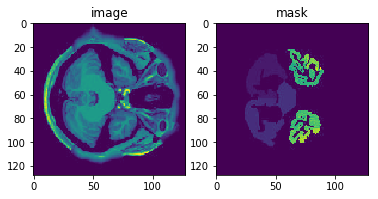

torch.Size([128, 128, 256])
tensor(1.)
tensor(0.)


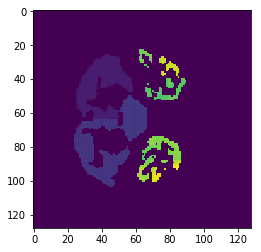

In [59]:
sample=train_data[5]
img = sample['T1a']
mask = sample['parc5a']

show_mask(img.squeeze(), mask)

img = img.unsqueeze(dim = 0)

img = img.to(device)


# feed it to network
scores =  unet(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)
print(scores.size())
scores = torch.exp(scores)
print(torch.max(scores))
print(torch.min(scores))
a,b = torch.max(scores,dim=2)
plt.imshow(b)


In [49]:
a = torch.Tensor([[1,2,3],[4,5,6]])
torch.max(a,dim=1)

(tensor([3., 6.]), tensor([2, 2]))